## Table of Contents

1. [Overview](#1.-Overview-of-Modeling-Notebook)
1. [Preprocessing](#1.-Preprocessing)
2. [Modeling](#2.-Modeling)
3. [Feature Selection](#3.-Feature-Selection)
5. [Results](#5.-Results)
6. [Conclusion](#6.-Conclusion)

Click here to jump to [Exploratory Data Analysis](./Exploratory_Data_Analysis.ipynb)

---

## 1. Overview of Modeling Notebook

This notebook continues from the [Exploratory Data Analysis](./Exploratory_Data_Analysis.ipynb), where data understand and data visualization took place.

During data preprocessing, outliers were removed, categorical data was encoded, skewed columns were transformed, and the data was standardized. Outliers were removed using the IQR method. Categorical data was encoded using OneHotEncoder and OrdinalEncoder both from feature_engine. Skewed columns were transformed using the Box-Cox method in PowerTransformer from Sklearn. The data was standardized using StandardScaler from sklearn. 

A baseline model was created and future models were compared to the baseline model to determine if the model’s performance was being improved. The main performance metric used to evaluate the success of the model was the Root Mean Square Error. The Mean Absolute Error and Root Square Error were also taken into account when evaluating the model's performance. Multiple different types of models were run and GridsearchCV was used to attempt to improve the models. Feature selection was implemented on the two best performing models (Linear Regression and Random Forest). Feature selection methods implemented were ANOVA, Lasso, and using only features of top importance determined by the coefficients. 

## 2. Preprocessing

### Data preprocessing & Continued Exploratory Analysis
Further exploratory analysis will give us a better look at outliers, multicollinearity, normality, and homoscedasticity. Exploratory analysis is a good way to better understand what preprocessing steps need to be made as we prepare for modeling.

Before we remove outliers or do any more preprocessing I will split the data into test and training sets to avoid data leakage.

In [81]:
# import all packages needed for modeling
import pandas as pd
import numpy as np
import seaborn as sns
from feature_engine.encoding import OrdinalEncoder
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from scipy.special import boxcox
from scipy.special import inv_boxcox
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
import warnings
import pylab
from patsy import dmatrices

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from feature_engine.encoding import OrdinalEncoder
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

In [82]:
# Import df from EDA & Preprocessing Notebook
regression = pd.read_csv('Data/regression.csv')

In [83]:
# rename columns to make them easier to understand
regression.rename(columns = {'bathrooms_text': 'bathrooms', 'neighbourhood_cleansed':'neighbourhood'}, inplace=True)

In [84]:
# perform a test train split
df_train, df_test = train_test_split(regression,random_state=42)
df_train.shape,df_test.shape

((4515, 24), (1506, 24))

Before outliers are removed we should run through some basic filter methods to make sure that we do not have constant or duplicated features. Even though this dataset does not have a ton of different features, it still is good practice to check for constant features. These are features that show a high percentage of the same value & they should be removed because in essence they are the same.

In [85]:
# check for quasi constant numerical variables
num_cols = ['bedrooms', 'beds', 'accommodates','price',
       'maximum_nights', 'minimum_nights','availability_30',
       'availability_365', 'number_of_reviews',
       'review_scores_rating','availability_90',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']

thresh = VarianceThreshold(threshold=0.01)  

thresh.fit(df_train[num_cols])

VarianceThreshold(threshold=0.01)

In [86]:
# double check that our variables are stored
sum(thresh.get_support())

16

In [87]:
# let's print the number of quasi-constant features & we see that there are no numerical columns that are quasi_constant
quasi_constant = df_train[num_cols].columns[~thresh.get_support()]

len(quasi_constant)

0

In [88]:
# create an empty list
cat_cols = ['host_is_superhost', 'neighbourhood', 'property_type', 'room_type','instant_bookable']
train_cat = df_train[cat_cols]

quasi_constant_var = []

# iterate over every feature
for var in train_cat.columns:

    # find predominant value for each variable
    predominant = train_cat[var].value_counts(
        normalize=True).sort_values(ascending=False).values[0]

    # 99% of values are the same
    if predominant > 0.998:

        # make list if yest
        quasi_constant_feat.append(var)

len(quasi_constant_var)

0

#### Remove outliers
Only remove outliers from the training set. Removing a lot of outliers is not ideal since we don't want to lose data. From data exploration we know that there are extreme outliers in many of the columns. With this dataset being smaller removing outliers will hopefully help our model's performance. 

In [89]:
# Make functions to easily view distribution
def plot_distribution(df_train, col='price'):
    # Plot displot + mean and mean
    median = df_train[col].median()
    mean = df_train[col].mean()
    fig, ax = plt.subplots(figsize=(5,5))
    sns.histplot(data=df_train[col], ax=ax)

    ax.set_title(F"Distribution of {col}")
    ax.axvline(median,label=f'median={median:,}',color='black')
    ax.axvline(mean,label=f'mean={mean:,}',color='black',ls=':')
    ax.legend()

In [90]:
# Make a function to find outlier using IQR method
# I want to keep as much data as possible so I am making my q1 small and my q3 large that the typical 4 even quantiles

def find_outliers_IQR(df_train):
    q1 = df_train.quantile(0.15)
    q3 = df_train.quantile(0.85)
    thresh = 1.5*(q3-q1)
    idx_outliers =(df_train < (q1-thresh)) | (df_train > (q3+thresh))
    return idx_outliers

In [91]:
# function to create histogram, Q-Q plot and boxplot

def diagnostic_plots(df_train, variable):
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    median = df_train[variable].median()
    mean = df_train[variable].mean()
    sns.histplot(df_train[variable], bins=40)
    
    plt.title(F"Distribution of {variable}")
    plt.axvline(median,label=f'median={median:,}',color='black')
    plt.axvline(mean,label=f'mean={mean:,}',color='black',ls=':')
    plt.legend()

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df_train[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df_train[variable])
    plt.title('Boxplot')

    plt.show()

In [92]:
# print the number of rows that contain outliers in price
price_outliers_IQR = find_outliers_IQR(df_train['price'])
price_outliers_IQR.sum()

141

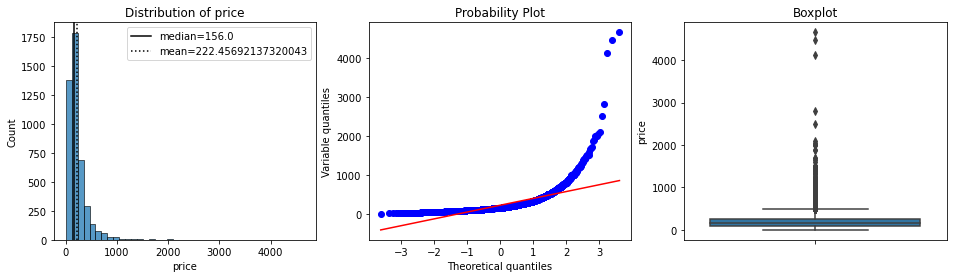

In [93]:
# Price is skewed and the outliers are impacting the normalcy
diagnostic_plots(df_train, 'price')

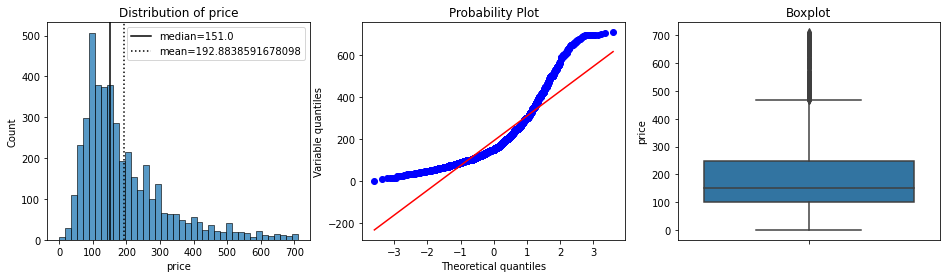

In [94]:
# See how removing these outliers would change the distribution
df_train = df_train[~price_outliers_IQR].copy()

# Remove outliers for visualization df 
diagnostic_plots(df_train, 'price')

In [95]:
# see if any listings have price set at $0
df_train.loc[df_train['price'] == 0]

,host_is_superhost,neighbourhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
4228,t,Marigny,Room in boutique hotel,Hotel room,4,1 bath,1.0,1.0,0.0,1,...,0,15,5.0,5.0,4.87,4.87,5.0,4.87,4.93,f


In [96]:
# drop row with price as $0
df_train.drop(4228, axis=0, inplace=True)

In [97]:
# see if any listings have price set at $0 in test set
df_test.loc[df_test['price'] == 0]

,host_is_superhost,neighbourhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
4280,f,Mid-City,Room in hotel,Hotel room,8,1 bath,1.0,1.0,0.0,1,...,0,0,4.86,4.91,4.88,4.96,4.95,4.87,4.83,f


In [98]:
# drop row with price as $0 in test set
df_test.drop(4280, axis=0, inplace=True)

In [99]:
# See about removing bedroom outliers
bedrooms_outliers_IQR = find_outliers_IQR(df_train['bedrooms'])
bedrooms_outliers_IQR.sum()

18

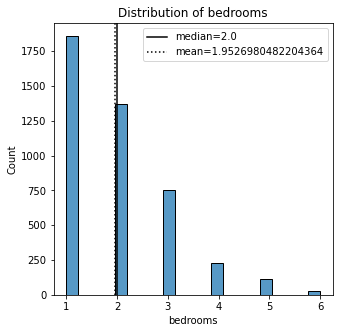

In [100]:
# visualize how many bedroom categories will be left after removing outliers
find_bedrooms = df_train[~bedrooms_outliers_IQR]
plot_distribution(find_bedrooms, 'bedrooms')

In [101]:
# See about removing bedroom outliers
beds_outliers_IQR = find_outliers_IQR(df_train['beds'])
beds_outliers_IQR.sum()

56

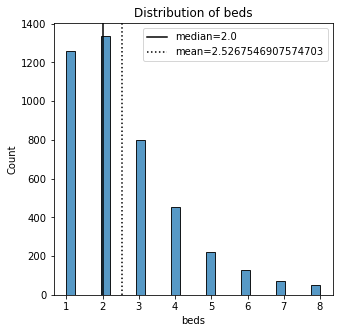

In [102]:
# visualize how many bedroom categories will be left after removing outliers
find_beds = df_train[~beds_outliers_IQR]
plot_distribution(find_beds, 'beds')

In [103]:
# create function to view distribution of the different columns related to reviews
review_cols = ['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'number_of_reviews']

def diagnostic_reviews(df_train, review_cols):
    
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,10), sharey=True)

    for col, ax in zip(review_cols, axes.flatten()):
        ax.hist(df_train[col], bins='auto')
        ax.set_title(col)
    
        median = df_train[col].median()
        mean = df_train[col].mean()
    
        ax.set_title(F"Distribution of {col}")
        ax.axvline(median,label=f'median={median:,}',color='black')
        ax.axvline(mean,label=f'mean={mean:,}',color='black',ls=':')
        ax.legend()
 
    fig.tight_layout()

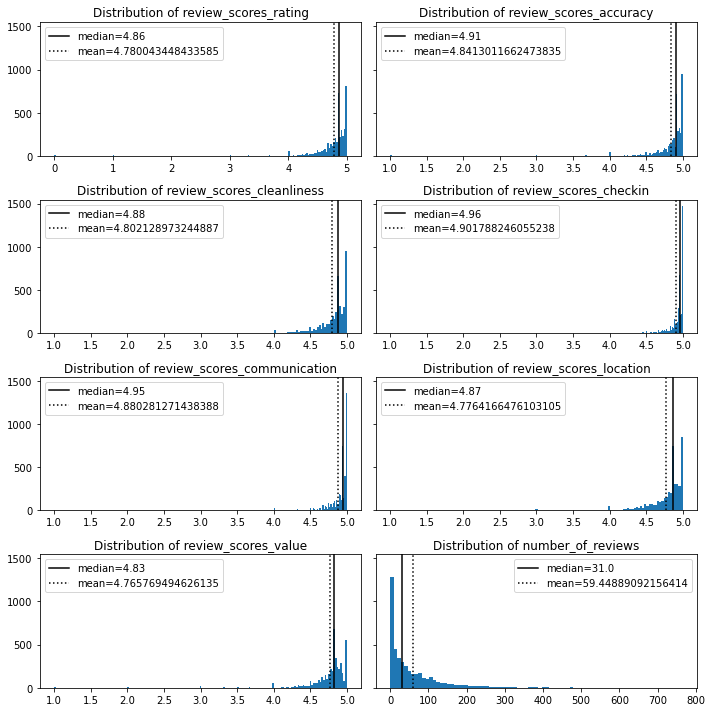

In [104]:
# viewing the distribution shows us that there are extreme outliers impacting the normality of this data
diagnostic_reviews(df_train, review_cols)

In [105]:
# print the number of rows that contain outliers in review_scores_rating
review_scores_rating_outliers_IQR = find_outliers_IQR(df_train['review_scores_rating'])
review_scores_rating_outliers_IQR.sum()

113

In [106]:
# print the number of rows that contain outliers in review_scores_location
review_scores_location_outliers_IQR = find_outliers_IQR(df_train['review_scores_location'])
review_scores_location_outliers_IQR.sum()

72

In [107]:
# print the number of rows that contain outliers in review_scores_communication
review_scores_communication_outliers_IQR = find_outliers_IQR(df_train['review_scores_communication'])
review_scores_communication_outliers_IQR.sum()

145

In [108]:
# print the number of rows that contain outliers in review_scores_checkin
review_scores_checkin_outliers_IQR = find_outliers_IQR(df_train['review_scores_checkin'])
review_scores_checkin_outliers_IQR.sum()

191

In [109]:
# print the number of rows that contain outliers in review_scores_cleanliness
review_scores_cleanliness_outliers_IQR = find_outliers_IQR(df_train['review_scores_cleanliness'])
review_scores_cleanliness_outliers_IQR.sum()

99

In [110]:
# print the number of rows that contain outliers in review_scores_accuracy
review_scores_accuracy_outliers_IQR = find_outliers_IQR(df_train['review_scores_accuracy'])
review_scores_accuracy_outliers_IQR.sum()

130

In [111]:
# print the number of rows that contain outliers in review_scores_value
review_scores_value_outliers_IQR = find_outliers_IQR(df_train['review_scores_value'])
review_scores_value_outliers_IQR.sum()

122

In [112]:
# print the number of rows that contain outliers in minimum_nights
min_night_outliers_IQR = find_outliers_IQR(df_train['minimum_nights'])
min_night_outliers_IQR.sum()

29

In [113]:
# print the number of rows that contain outliers in maximum_nights
max_night_outliers_IQR = find_outliers_IQR(df_train['maximum_nights'])
max_night_outliers_IQR.sum()

1

In [114]:
# print the number of rows that contain outliers in number_of_reviews
number_reviews_IQR = find_outliers_IQR(df_train['number_of_reviews'])
number_reviews_IQR.sum()

92

In [115]:
# Again we want to remove as few rows as possible so for bathrooms we will make a 5 or more columns instead
df_train.loc[df_train['bathrooms'].str.contains("1|0"),'bathrooms'] = '1 bath'
df_train.loc[df_train['bathrooms'].str.contains("2"),'bathrooms'] = '2 baths'
df_train.loc[df_train['bathrooms'].str.contains("3"),'bathrooms'] = '3 baths'
df_train.loc[df_train['bathrooms'].str.contains("4"),'bathrooms'] = '4 baths'
df_train.loc[df_train['bathrooms'].str.contains("5|6|7|8|9"),'bathrooms'] = '5 or more baths'

#same for test set
df_test.loc[df_test['bathrooms'].str.contains("1|0"),'bathrooms'] = '1 bath'
df_test.loc[df_test['bathrooms'].str.contains("2"),'bathrooms'] = '2 baths'
df_test.loc[df_test['bathrooms'].str.contains("3"),'bathrooms'] = '3 baths'
df_test.loc[df_test['bathrooms'].str.contains("4"),'bathrooms'] = '4 baths'
df_test.loc[df_test['bathrooms'].str.contains("5|6|7|8|9"),'bathrooms'] = '5 or more baths'

df_train['bathrooms'].value_counts()

1 bath             2805
2 baths            1293
3 baths             196
4 baths              62
5 or more baths      17
Name: bathrooms, dtype: int64

In [116]:
# Remove outliers from the training dataset
rating_outliers = (review_scores_rating_outliers_IQR | review_scores_value_outliers_IQR | 
                              review_scores_checkin_outliers_IQR | review_scores_communication_outliers_IQR |
                              review_scores_location_outliers_IQR | review_scores_accuracy_outliers_IQR |
                              review_scores_cleanliness_outliers_IQR | min_night_outliers_IQR | max_night_outliers_IQR|
                              beds_outliers_IQR | bedrooms_outliers_IQR | number_reviews_IQR)

df_train = df_train[~rating_outliers].copy()

In [117]:
# make df_clean 
df_train.shape

(3793, 24)

df_train started with 4515 rows and ended with 3793 rows

In [118]:
# look at the distribution of the numerical data as we prepare for encoding that categorical variables
review_num = ['price', 'accommodates', 'maximum_nights', 'minimum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews' ]

def diagnostic_reviews_num(df_train, review_num):
    
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,10), sharey=False)

    for col, ax in zip(review_num, axes.flatten()):
        ax.hist(df_train[col], bins='auto')
        ax.set_title(col)
    
        median = df_train[col].median()
        mean = df_train[col].mean()
    
        ax.set_title(F"Distribution of {col}")
        ax.axvline(median,label=f'median={median:,}',color='black')
        ax.axvline(mean,label=f'mean={mean:,}',color='black',ls=':')
        ax.legend()
 
    fig.tight_layout()

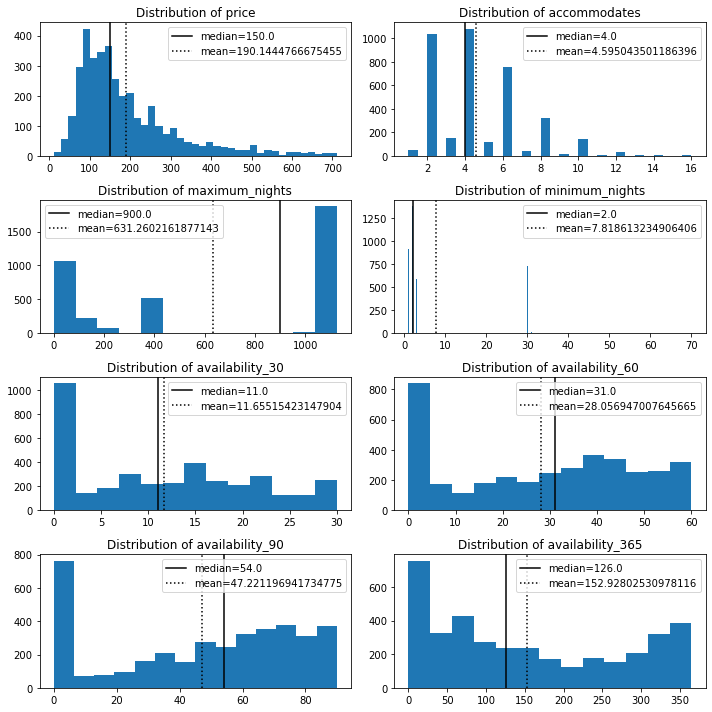

In [119]:
diagnostic_reviews_num(df_train, review_num)

In [120]:
# check to make sure minimum_nights shouldnt be considered a categorical feature
df_train['minimum_nights'].value_counts()

2     1385
1      913
30     736
3      592
4       61
5       28
7       23
31      15
6        8
60       8
28       7
15       4
14       3
10       2
32       2
29       1
70       1
12       1
18       1
9        1
59       1
Name: minimum_nights, dtype: int64

In [121]:
# beds and bedrooms need to be in object form to encode
change_type = {'beds': object,
                'bedrooms': object
                }
df_train = df_train.astype(change_type)
df_test = df_test.astype(change_type)

In [122]:
# ordinal encoder
ordinal_enc = OrdinalEncoder(
    encoding_method='arbitrary',
    variables=['host_is_superhost', 'bathrooms', 'beds', 'bedrooms'])

ordinal_enc.fit(df_train)
#ordinal_enc.fit(df_test_encoded)

OrdinalEncoder(encoding_method='arbitrary',
               variables=['host_is_superhost', 'bathrooms', 'beds', 'bedrooms'])

In [123]:
# make sure that everything looks good for the ordinal encoder
ordinal_enc.encoder_dict_

{'host_is_superhost': {'t': 0, 'f': 1},
 'bathrooms': {'1 bath': 0,
  '2 baths': 1,
  '3 baths': 2,
  '4 baths': 3,
  '5 or more baths': 4},
 'beds': {1.0: 0, 3.0: 1, 2.0: 2, 4.0: 3, 6.0: 4, 5.0: 5, 8.0: 6, 7.0: 7},
 'bedrooms': {1.0: 0, 2.0: 1, 4.0: 2, 3.0: 3, 5.0: 4, 6.0: 5}}

In [124]:
# need to set a max for the test set for beds or bedrooms or we will get NaN when encoding the test set
df_test.loc[(df_test['bedrooms'] >= 6.0), 'bedrooms'] = 6.0
df_test.loc[(df_test['beds'] >= 7.0), 'beds'] = 7.0

In [125]:
# encode the test and training sets
df_train_ord = ordinal_enc.transform(df_train)
df_test_ord = ordinal_enc.transform(df_test)

In [126]:
# make sure there is no NaN values created during encoding
df_test_ord.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1505 entries, 5107 to 4404
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            1505 non-null   int64  
 1   neighbourhood                1505 non-null   object 
 2   property_type                1505 non-null   object 
 3   room_type                    1505 non-null   object 
 4   accommodates                 1505 non-null   int64  
 5   bathrooms                    1505 non-null   int64  
 6   bedrooms                     1505 non-null   int64  
 7   beds                         1505 non-null   int64  
 8   price                        1505 non-null   float64
 9   minimum_nights               1505 non-null   int64  
 10  maximum_nights               1505 non-null   int64  
 11  availability_30              1505 non-null   int64  
 12  availability_60              1505 non-null   int64  
 13  availability_90

In [127]:
# use one hot encoder on the remaining categorical variables
ohe_enc = fe_OneHotEncoder(variables=['neighbourhood', 'property_type',
                                      'room_type', 'instant_bookable'], drop_last=True)

# fit to df_train
ohe_enc.fit(df_train_ord)

OneHotEncoder(drop_last=True,
              variables=['neighbourhood', 'property_type', 'room_type',
                         'instant_bookable'])

In [128]:
# ignore warning
warnings.filterwarnings('ignore')

# transform training set
df_train_encoded = ohe_enc.transform(df_train_ord)

In [129]:
# ignore warning
warnings.filterwarnings('ignore')

# transform the test set
df_test_encoded = ohe_enc.transform(df_test_ord)

In [130]:
# Make sure train set looks right
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3793 entries, 2025 to 860
Columns: 134 entries, host_is_superhost to instant_bookable_t
dtypes: float64(8), int64(126)
memory usage: 3.9 MB


In [131]:
# Make sure test set looks right
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1505 entries, 5107 to 4404
Columns: 134 entries, host_is_superhost to instant_bookable_t
dtypes: float64(8), int64(126)
memory usage: 1.6 MB


In [132]:
# see which predictors have high correlation which each other
correlation = df_train_encoded.corr().abs().stack().reset_index().sort_values(0, ascending=False)

correlation['pairs'] = list(zip(correlation.level_0, correlation.level_1))

correlation.set_index(['pairs'], inplace = True)

correlation.drop(columns=['level_1', 'level_0'], inplace = True)

correlation.columns = ['corr_coef']

correlation[(correlation.corr_coef>.75) & (correlation.corr_coef<1)]

,corr_coef
pairs,
"(availability_90, availability_60)",0.951020
"(availability_60, availability_90)",0.951020
"(room_type_Private room, room_type_Entire home/apt)",0.932969
"(room_type_Entire home/apt, room_type_Private room)",0.932969
"(availability_60, availability_30)",0.921863
"(availability_30, availability_60)",0.921863
"(availability_30, availability_90)",0.840949
"(availability_90, availability_30)",0.840949
"(accommodates, bedrooms)",0.800725


When two columns have a high correlation it will hurt the model's performance. To help solve the issue of multicollinearity we will eliminate one column from each highly correlated pair. In this case I will remove `availability_90`, `property_type_Shared room in residential home`, `availability_60`, `accommodates`, `review_scores_value` and `review_scores_accuracy`.

In [133]:
# Remove one column from each highly correlated pair
df_train_encoded.drop(['availability_90','room_type_Entire home/apt', 'review_scores_accuracy', 'accommodates',
                      'availability_60', 'review_scores_value'], axis=1, inplace=True)

In [134]:
# Remove same columns from the test set
df_test_encoded.drop(['availability_90','room_type_Entire home/apt', 'review_scores_accuracy', 'accommodates',
                      'availability_60', 'review_scores_value'], axis=1, inplace=True)

We know that a few of the continious variables are very skewed, which could have a negative impact on our model. Before we move onto modeling we should try to eliviate some of the skewiness with a transfomation. 

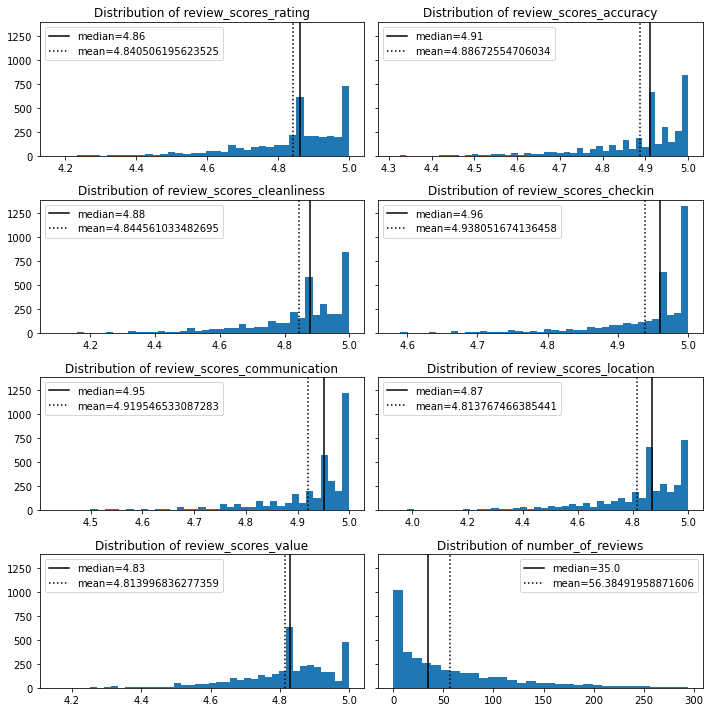

In [135]:
# recall the skewed variables
diagnostic_reviews(df_train, review_cols)

In [136]:
# take a look at how skewed the continuous features are

def print_skewness(df):
    print(f'''The skewness of the cleanliness score is:\
    {df["review_scores_cleanliness"].skew():.2f}''')

    print(f'''The skewness of the overall rating is:\
     {df["review_scores_rating"].skew():.2f}''')

    print(f'''The skewness of the communication score is: \
     {df["review_scores_communication"].skew():.2f}''')

    print(f'''The skewness of the location score is: \
     {df["review_scores_location"].skew():.2f}''')

    print(f'''The skewness of the checkin score is: \
     {df["review_scores_checkin"].skew():.2f}''')

    print(f'''The skewness of the number of reviews is: \
     {df["number_of_reviews"].skew():.2f}''')

    print(f'''The skewness of the price is: \
     {df["price"].skew():.2f}''')

In [137]:
# view skewness
print_skewness(df_train_encoded)

The skewness of the cleanliness score is:    -1.64
The skewness of the overall rating is:     -1.40
The skewness of the communication score is:      -1.93
The skewness of the location score is:      -1.70
The skewness of the checkin score is:      -1.88
The skewness of the number of reviews is:      1.45
The skewness of the price is:      1.61


We have removed the outliers for these columns yet skewness is still an issue. First we will try a log transformation then a boxcox.

In [138]:
# To do log or boxcox transformation there cannot be any zero values. 
# I will change all listings that have 0 reviews to having 1 review

df_train_encoded.loc[(df_train_encoded['number_of_reviews'] == 0), 'number_of_reviews'] = 1
df_test_encoded.loc[(df_test_encoded['number_of_reviews'] == 0), 'number_of_reviews'] = 1

df_train_encoded.loc[(df_train_encoded['review_scores_rating'] == 0), 'review_scores_rating'] = 1
df_test_encoded.loc[(df_test_encoded['review_scores_rating'] == 0), 'review_scores_rating'] = 1

df_train_encoded['number_of_reviews'].describe()

count    3793.000000
mean       56.502768
std        62.149333
min         1.000000
25%         8.000000
50%        35.000000
75%        84.000000
max       294.000000
Name: number_of_reviews, dtype: float64

In [139]:
# perform log transformation on skewed columns 
skewed_cols = ['number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin','review_scores_communication',
       'review_scores_location', 'price']

train_log = df_train_encoded.copy()
test_log = df_test_encoded.copy()

train_log[skewed_cols] = np.log(df_train_encoded[skewed_cols])
test_log[skewed_cols] = np.log(df_test_encoded[skewed_cols])


In [140]:
# we see that the log transformation did not really help so we will go with boxcox instead
print_skewness(train_log)

The skewness of the cleanliness score is:    -1.77
The skewness of the overall rating is:     -1.51
The skewness of the communication score is:      -2.00
The skewness of the location score is:      -1.84
The skewness of the checkin score is:      -1.93
The skewness of the number of reviews is:      -0.64
The skewness of the price is:      0.04


In [141]:
# before we seperate the target variable lets see how many rows are left after preprocessing
print({df_train_encoded.shape})
print({df_test_encoded.shape})

{(3793, 128)}
{(1505, 128)}


In [142]:
df_train_encoded['beds'].info()

<class 'pandas.core.series.Series'>
Int64Index: 3793 entries, 2025 to 860
Series name: beds
Non-Null Count  Dtype
--------------  -----
3793 non-null   int64
dtypes: int64(1)
memory usage: 59.3 KB


In [143]:
# separate target variable from predictor variables
target = 'price'

y_train = df_train_encoded[target].copy()
X_train = df_train_encoded.drop(target, axis=1).copy()
y_test = df_test_encoded[target].copy()
X_test = df_test_encoded.drop(target, axis=1).copy()

In [144]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3793 entries, 2025 to 860
Columns: 127 entries, host_is_superhost to instant_bookable_t
dtypes: float64(5), int64(122)
memory usage: 3.7 MB


In [145]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 3793 entries, 2025 to 860
Series name: price
Non-Null Count  Dtype  
--------------  -----  
3793 non-null   float64
dtypes: float64(1)
memory usage: 59.3 KB


In [146]:
# turn y sets back to dfs
y_train = y_train.to_frame()
y_test = y_test.to_frame()

In [147]:
# make a list of just the skewed predictor variables for transformation
skewed_cols_X = ['number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin','review_scores_communication',
       'review_scores_location']

In [148]:
# boxcox transformation
####
y_test_bc = y_test.copy()

X_train_bc = X_train.copy()
y_train_bc = y_train.copy()
X_test_bc = X_test.copy()

# create the transformer
transformer = PowerTransformer(method='box-cox', standardize=False)

# create the transformer for y
transformer_y = PowerTransformer(method='box-cox', standardize=False)

#fit the y_transformer on y_train
transformer_y.fit(y_train_bc)

###
#transformer_y.fit(y_train_bc)

# transform test and train sets
transformer_y.transform(y_test_bc)
transformer_y.transform(y_train_bc)

# fit the x transformer on X_train
transformer.fit(X_train_bc[skewed_cols_X])

# transform the X training and test sets 
X_train_bc[skewed_cols_X] = transformer.transform(X_train_bc[skewed_cols_X])
X_test_bc[skewed_cols_X] = transformer.transform(X_test_bc[skewed_cols_X])

In [149]:
# we need to know lambda for interpretation of the RMSE during modeling
def boxcox(df, var):

    box_var = stats.boxcox(df[var])

    print(f'''The lambda used for {var} is\
     {box_var[1]:.7f}''')

In [150]:
# we will use this lambda in the modeling notebook to get the RMSE
boxcox(y_train_bc, 'price')

The lambda used for price is     -0.0207010


In [151]:
X_train_bc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3793 entries, 2025 to 860
Columns: 127 entries, host_is_superhost to instant_bookable_t
dtypes: float64(6), int64(121)
memory usage: 3.7 MB


In [152]:
# setup standardScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()

In [153]:
# fit on x_train
scaler_x.fit(X_train_bc)
# fit on y_train
scaler_y.fit(y_train_bc)

# transform X_train & X_test
X_train_scaled = scaler_x.transform(X_train_bc)
X_test_scaled = scaler_x.transform(X_test_bc)

# transform y_train & y_test only 
y_train_scaled = scaler_y.transform(y_train_bc)
y_test_scaled = scaler_y.transform(y_test_bc)


In [154]:
# turn scaled data back into dataframes
X_train = pd.DataFrame(X_train_scaled, columns=X_train_bc.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_bc.columns)
y_train = pd.DataFrame(y_train_scaled, columns=y_train_bc.columns)
y_test = pd.DataFrame(y_test_scaled, columns=y_test_bc.columns)
np.round(X_train.describe(), 1)

,host_is_superhost,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_365,number_of_reviews,review_scores_rating,...,property_type_Shared room in tiny house,property_type_Barn,property_type_Room in serviced apartment,property_type_Farm stay,property_type_Room in resort,property_type_Entire home/apt,property_type_Shared room in condominium (condo),room_type_Private room,room_type_Shared room,instant_bookable_t
count,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,...,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0
mean,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.1,-0.7,-0.9,-1.1,-0.6,-1.3,-1.2,-1.2,-1.6,-2.2,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.4,-0.1,-1.0
25%,-1.1,-0.7,-0.9,-1.1,-0.5,-1.1,-1.2,-0.9,-0.8,-0.7,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.4,-0.1,-1.0
50%,1.0,-0.7,-0.1,0.2,-0.5,0.5,-0.1,-0.2,0.1,-0.1,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.4,-0.1,1.0
75%,1.0,0.9,0.8,0.2,-0.4,1.0,0.8,1.0,0.8,0.8,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.4,-0.1,1.0
max,1.0,5.5,3.3,3.3,5.4,1.0,1.9,1.7,2.0,1.4,...,43.5,61.6,61.6,43.5,61.6,61.6,61.6,2.6,12.8,1.0


# 2. Modeling
The baseline model will be a Linear Regression model.

I will make a funtion to evaluate our model's performance. A breif overview of the different metrics:
- Mean Absolute Error (MAE): A basic metric that gives us the absolute difference between actual and predicted values. Idealy the final model would have a smaller MAE than the baseline model since we aim to lower the amount of error by tuning models.
- Mean Squared Error (MSE): Finds the squared difference between the actual and predicted values. The MSE is helpful since it avoids the cancellation of negative terms (unlike MAE). However, outliers will be more damaging since it penalizes the outliers more than MAE. 
- Root Mean Square Error(RMSE): Is the square root of the MSE. RMSE is easier to interpret than MSE since the output is in the same units as the variable

In [155]:
# function to view model's performance
def performance_metrics(model, X_test, y_test):
    
    # need to set up standard scaler to transform predictions back to orginal form for interpretation
    scaler_y = StandardScaler()
    scaler_y.fit(y_train)
    
    
    # get prediction on X_train
    train_pred = model.predict(X_train)
    # reshape to work with tree models
    train_pred = train_pred.reshape(-1,1)
    # inverse transform StandardScaler
    train_pred_inv_SS = scaler_y.inverse_transform(train_pred)
    # inverse transform BoxCox, lambda is from preprocessing notebook
    train_pred_inv_BC = (inv_boxcox(train_pred_inv_SS,-0.0207010))
    
    
    # get prediction on X_test
    test_pred = model.predict(X_test)
    # reshape to work with tree models
    test_pred = test_pred.reshape(-1,1)
    # inverse transform StandardScaler
    test_pred_inv_SS = scaler_y.inverse_transform(test_pred)
    # inverse transform BoxCox, lambda is from preprocessing notebook
    test_pred_inv_BC = (inv_boxcox(test_pred_inv_SS,-0.0207010))
    
    
    print(f'Test Mean Absolute Error : {round(mean_absolute_error(y_test,test_pred_inv_BC),2)}')
    print(f'Test Mean Squared Error: {round(mean_squared_error(y_test,test_pred_inv_BC),2)}')
    print(f'Test Root Mean Square Error :$ {round(np.sqrt(mean_squared_error(y_test,test_pred_inv_BC)),2)}')
    print(f'Train Root Mean Square Error :$ {round(np.sqrt(mean_squared_error(y_train,train_pred_inv_BC)),2)}')

### Baseline Model
For the baseline model I am choosing to do linear regression since it a simiple model. 

In [156]:
# Linear regression is base model
lr_base = LinearRegression()
lr_base.fit(X_train, y_train)

performance_metrics(lr_base, X_test, y_test)

Test Mean Absolute Error : 1.79
Test Mean Squared Error: 10.11
Test Root Mean Square Error :$ 3.18
Train Root Mean Square Error :$ 2.07


To rely on a linear regression model it must meet the assumptions of linear regression. We will take a look at the assuptions next, 

In [157]:
# get residuals to look at assumptions of linear regression
test_pred = lr_base.predict(X_test)
residuals = y_test - test_pred

<AxesSubplot:ylabel='Density'>

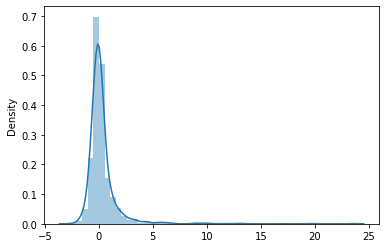

In [158]:
# look at normailty: the residuals of the Linear regression model are skewed
warnings.filterwarnings('ignore')
sns.distplot(residuals)

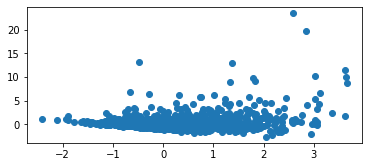

In [159]:
#The residuals do show a slight cone shape pattern 
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(test_pred, residuals)

In [161]:
# Double check for multicollinearity
X_num = X_train[['maximum_nights', 'availability_30', 'availability_365',
       'number_of_reviews', 'review_scores_rating',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_num.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i)
                          for i in range(len(X_num.columns))]
  
print(vif_data)

                       feature       VIF
0               maximum_nights  1.007739
1              availability_30  1.268117
2             availability_365  1.270027
3            number_of_reviews  1.111386
4         review_scores_rating  3.491498
5    review_scores_cleanliness  2.255183
6        review_scores_checkin  2.052931
7  review_scores_communication  2.405259
8       review_scores_location  1.320121


We see the baseline model has a RMSE of $\$$3.18 which indicates from the start this is a pretty well performing model. Since the average price overall is around $\$$190, a error of $\$$3.18 is not very off from the actual price.

## Model 2
For regression there are many different model types to choose from. Next, I am going to try a Random Forrest Model which is a little more robust to outliers than a Linear Regression model is. 

In [162]:
# Import Random Forest
forest_baseline = RandomForestRegressor()
forest_baseline.fit(X_train, y_train.values.ravel())

# view performance metrics
performance_metrics(forest_baseline, X_test, y_test)


Test Mean Absolute Error : 1.82
Test Mean Squared Error: 8.02
Test Root Mean Square Error :$ 2.83
Train Root Mean Square Error :$ 3.3


The RandomForest model did perform better than the linear regression model

In [163]:
# Use gridsearch to find a better RandomForest model
# I will start with a spread of different parameter options
param = {
    'criterion': ['squared_error'],
    'max_depth': [10, 50, 75],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [10, 30, 50],
    'min_samples_split': [2, 5, 10],
}

gridsearch_rf1 = GridSearchCV(estimator=forest_baseline,
                          param_grid=param, cv= 3, scoring='neg_mean_squared_error')

# Run search & takes a while to run
gridsearch_rf1.fit(X_train, y_train.values.ravel())
gridsearch_rf1.best_params_

{'criterion': 'squared_error',
 'max_depth': 75,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10}

In [164]:
# view performance metrics
performance_metrics(gridsearch_rf1, X_test, y_test)

Test Mean Absolute Error : 1.65
Test Mean Squared Error: 5.51
Test Root Mean Square Error :$ 2.35
Train Root Mean Square Error :$ 1.99


In [104]:
# Use gridsearch to find a better RandomForest model
# I will start with a spread of different parameter options
param = {
    'criterion': ['squared_error'],
    'max_depth': [75, 80, 95],
    'max_features': ['auto'],
    'min_samples_leaf': [5, 7, 10],
    'min_samples_split': [8, 10, 12],
}

gridsearch_rf2 = GridSearchCV(estimator=forest_baseline,
                          param_grid=param, cv= 3, scoring='neg_mean_squared_error')

# Run search & takes a while to run
gridsearch_rf2.fit(X_train, y_train.values.ravel())
gridsearch_rf2.best_params_

{'criterion': 'squared_error',
 'max_depth': 75,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 12}

In [105]:
# view performance metrics
performance_metrics(gridsearch_rf2, X_test, y_test)

Test Mean Absolute Error : 1.68
Test Mean Squared Error: 6.02
Test Root Mean Square Error :$ 2.45
Train Root Mean Square Error :$ 2.23


In [89]:
# to better understand how the different parameters performed we can visualize the data
results = pd.DataFrame(gridsearch_rf1.cv_results_)
results.sort_values(by='mean_test_score', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
print(results.shape)

results.head(2)

(54, 16)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.945939,0.013155,0.018245,0.000735,squared_error,75,auto,10,2,"{'criterion': 'squared_error', 'max_depth': 75...",-0.488902,-0.446114,-0.417948,-0.450988,0.029171,1
1,0.997878,0.023809,0.019557,0.000672,squared_error,75,auto,10,10,"{'criterion': 'squared_error', 'max_depth': 75...",-0.487764,-0.451567,-0.415416,-0.451582,0.029536,2


Text(0.5, 0, 'Hyperparameter combinations')

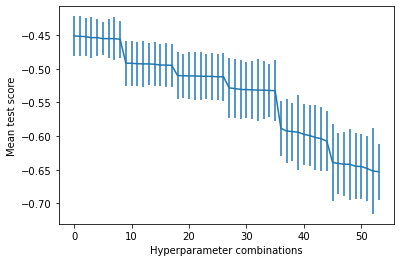

In [90]:
# plot model performance and error
results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

Random Forest model improved after hyperparameter tuning and is a little better than the baseline model.

## Model 4
XGBoost

In [84]:
# set up xgboost model
warnings.filterwarnings('ignore')

xgbr = xgb.XGBRegressor()
xgbr.fit(X_train, y_train)

performance_metrics(xgbr, X_test, y_test)


Test Mean Absolute Error : 2.22
Test Mean Squared Error: 23.51
Test Root Mean Square Error :$ 4.85
Train Root Mean Square Error :$ 4.56


In [92]:
# block warning about deprecated int64
warnings.filterwarnings('ignore')

param_grid = {"max_depth":    [5, 6, 7],
              "n_estimators": [600, 700, 800],
              "learning_rate": [0.01, 0.015, 0.25]}

xgb_search = GridSearchCV(xgbr, param_grid, cv=3, scoring='neg_mean_squared_error').fit(X_train, y_train)

# Run search & takes a min or two
xgb_search.fit(X_train, y_train.values.ravel())
xgb_search.best_params_

{'learning_rate': 0.015, 'max_depth': 5, 'n_estimators': 800}

In [93]:
# view performance metrics
performance_metrics(xgb_search, X_test, y_test)

Test Mean Absolute Error : 1.89
Test Mean Squared Error: 10.98
Test Root Mean Square Error :$ 3.31
Train Root Mean Square Error :$ 2.76


In [94]:
# make basic decision tree model
from sklearn.tree import DecisionTreeRegressor

tree_baseline = DecisionTreeRegressor()
tree_baseline.fit(X_train, y_train)

performance_metrics(tree_baseline,X_test,y_test)

Test Mean Absolute Error : 3.27
Test Mean Squared Error: 85.61
Test Root Mean Square Error :$ 9.25
Train Root Mean Square Error :$ 6.64


Decision Tree and Xgboost did much worse than the baseline model and the Random Forest models.

## 3. Feature Selection
Feature selection algorithms can be seen as a combination of search techniques for suggesting which features to use in a model. In the Preprocessing notebook filter methods were used for feature selection, such as looking at corrilation. 

First atempt to use only the features with a significant F score for linear regression model and the random forest model since those are our best performing models. As well, we will attempt the LASSO method which is an embedded feature selection method, meaning feature selection is performed during the modeling algorithm's execution. 

In [79]:
# make the performance fuction again this time using selecet_test
def performance_selection(model, select_test, y_test):
    
    scaler_y = StandardScaler()
    scaler_y.fit(y_train)
    
    # get prediction on X_train
    train_pred = model.predict(select_train)
    # get prediction on X_test
    # reshape to work with tree models
    train_pred = train_pred.reshape(-1,1)
    # inverse transform StandardScaler
    train_pred_inv_SS = scaler_y.inverse_transform(train_pred)
    # inverse transform BoxCox, lambda is from preprocessing notebook
    train_pred_inv_BC = (inv_boxcox(train_pred_inv_SS,-0.0207010))
    
    # get prediction on X_test
    test_pred = model.predict(select_test)
    # reshape to work with tree models
    test_pred = test_pred.reshape(-1,1)
    # inverse transform StandardScaler
    test_pred_inv_SS = scaler_y.inverse_transform(test_pred)
    # inverse transform BoxCox
    test_pred_inv_BC = (inv_boxcox(test_pred_inv_SS,-0.0207010))
    
    print(f'Test Mean Absolute Error : {round(mean_absolute_error(y_test,test_pred_inv_BC),2)}')
    print(f'Test Mean Squared Error: {round(mean_squared_error(y_test,test_pred_inv_BC),2)}')
    print(f'Test Root Mean Square Error :$ {round(np.sqrt(mean_squared_error(y_test,test_pred_inv_BC)),2)}')
    print(f'Train Root Mean Square Error :$ {round(np.sqrt(mean_squared_error(y_train,train_pred_inv_BC)),2)}')

In [91]:
# try feature selection on linear regression model
sel_linear = SelectFromModel(LinearRegression())

sel_linear.fit(X_train, y_train)

SelectFromModel(estimator=LinearRegression())

In [92]:
# let's count the number of variables selected
selected_feat_linear = X_train.columns[(sel_linear.get_support())]

len(selected_feat_linear)

43

In [93]:
print('total features: {}'.format((X_train.shape[1])))

print('selected features: {}'.format(len(selected_feat_linear)))

print(
    'features with coefficients greater than the mean coefficient: {}'.format(
        np.sum(
            np.abs(sel_linear.estimator_.coef_) > np.abs(
                sel_linear.estimator_.coef_).mean())))

total features: 127
selected features: 43
features with coefficients greater than the mean coefficient: 43


In [94]:
# create X train and test for just selected features
select_train = X_train[selected_feat_linear]
select_test = X_test[selected_feat_linear]

In [95]:
# take a look the features that were selected
select_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3793 entries, 0 to 3792
Data columns (total 43 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   bathrooms                                       3793 non-null   float64
 1   bedrooms                                        3793 non-null   float64
 2   beds                                            3793 non-null   float64
 3   availability_30                                 3793 non-null   float64
 4   neighbourhood_Bayou St. John                    3793 non-null   float64
 5   neighbourhood_Bywater                           3793 non-null   float64
 6   neighbourhood_Leonidas                          3793 non-null   float64
 7   neighbourhood_Central Business District         3793 non-null   float64
 8   neighbourhood_Irish Channel                     3793 non-null   float64
 9   neighbourhood_French Quarter             

We see here that top important features are all categorical, this is a good indicator to why feature selection is proving not be that benificial to the models. It is important to have some continious features in a predictive model. 

In [96]:
# fit selected features to linear regression model
linear_sel = LinearRegression()
linear_sel.fit(select_train, y_train)

# view performance of model
performance_selection(linear_sel, select_test, y_test)

Test Mean Absolute Error : 1.47
Test Mean Squared Error: 4.18
Test Root Mean Square Error :$ 2.04
Train Root Mean Square Error :$ 1.43


In [101]:
# fit selected features to linear regression model
RandomForest_sel = gridsearch_rf1
RandomForest_sel.fit(select_train, y_train)

# view performance of model
performance_selection(RandomForest_sel, select_test, y_test)

Test Mean Absolute Error : 1.45
Test Mean Squared Error: 4.09
Test Root Mean Square Error :$ 2.02
Train Root Mean Square Error :$ 1.39


In [97]:
# set up Lasso for linear regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
lasso = SelectFromModel(Lasso(alpha=1, random_state=10))
lasso.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=1, random_state=10))

In [98]:
# make a list with the selected features and print the outputs
selected_feat = X_train.columns[(lasso.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(lasso.estimator_.coef_ == 0)))

total features: 127
selected features: 0
features with coefficients shrank to zero: 127


Lasso shows to be not helpful as all coefficients were shrank to zero but one variable. 

### Using filter method ANOVA 

<AxesSubplot:>

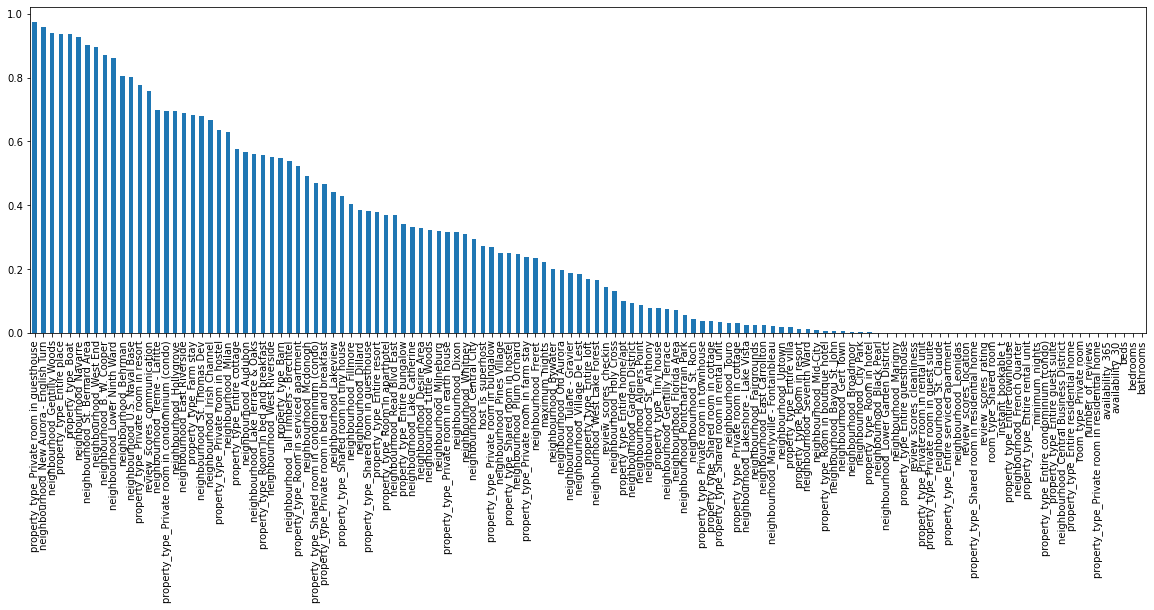

In [165]:
# Run ANOVA test to get a understanding of possible dependency 
from sklearn.feature_selection import f_regression
anova = f_regression(X_train, y_train)

# plot values
anova = pd.Series(anova[1])
anova.index = X_train.columns
anova.sort_values(ascending=False).plot.bar(figsize=(20,6))

In [166]:
# select the top 20% of features based on dependancy
from sklearn.feature_selection import SelectKBest, SelectPercentile
percentile = SelectPercentile(f_regression,
                        percentile=20).fit(X_train, y_train)

# display selected feature names
precent20_cols = X_train.columns[percentile.get_support()]

In [167]:
# once again we see that many of these featuers are categorical
precent20_cols 

Index(['bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'availability_30',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_location', 'neighbourhood_Leonidas',
       'neighbourhood_Central Business District',
       'neighbourhood_French Quarter', 'neighbourhood_St. Claude',
       'property_type_Entire rental unit',
       'property_type_Entire residential home',
       'property_type_Private room in guest suite',
       'property_type_Private room in residential home',
       'property_type_Shared room in residential home',
       'property_type_Entire guest suite', 'property_type_Entire townhouse',
       'property_type_Entire condominium (condo)',
       'property_type_Private room in rental unit',
       'property_type_Entire serviced apartment', 'room_type_Private room',
       'room_type_Shared room', 'instant_bookable_t'],
      dtype='object')

In [168]:
# create X train and test for just selected features
select_train = X_train.drop(precent20_cols, axis=1)
select_test = X_test.drop(precent20_cols, axis=1)

In [169]:
# fit the selected features of linear regression
precent20 = LinearRegression()
precent20.fit(select_train, y_train)

performance_selection(precent20, select_test, y_test)

Test Mean Absolute Error : 1.47
Test Mean Squared Error: 4.18
Test Root Mean Square Error :$ 2.04
Train Root Mean Square Error :$ 1.43


In [170]:
# fit the selected features of linear regression
precent20_rf = gridsearch_rf1
precent20_rf.fit(select_train, y_train)

performance_selection(precent20_rf, select_test, y_test)

Test Mean Absolute Error : 1.45
Test Mean Squared Error: 4.09
Test Root Mean Square Error :$ 2.02
Train Root Mean Square Error :$ 1.39


Feature selection methods have only hurt our model so far.

### Removing neighboorhood data

Over half the features in this analysis are different neighboorhoods, we can see if there is any change if we dont take the neighbourhood features into account. Many models can be bais or in a way confused by the weak relationships it finds between the categorical features. 

In [118]:
# remove all neighboorhood columns for both test and train sets
select_train = X_train[X_train.columns.drop(list(X_train.filter(regex='neighbourhood')))]
select_test = X_test[X_test.columns.drop(list(X_test.filter(regex='neighbourhood')))]

In [120]:
# fit model
gridsearch_rf1.fit(select_train, y_train)

# view performance 
performance_selection(gridsearch_rf1, select_test, y_test)

Test Mean Absolute Error : 1.65
Test Mean Squared Error: 5.63
Test Root Mean Square Error :$ 2.37
Train Root Mean Square Error :$ 2.02


We see that removing the neighbourhood data did not prove to help the model.

### Exploring other options
Similar to feature to selection we can look at principal component analysis to help reduce dimensionality of the dataset.

In [105]:
# set up pca
pca_model = PCA(n_components=115)

# fit on X_train
pca_model.fit(X_train)

PCA(n_components=115)

In [106]:
# 
np.sum(pca_model.explained_variance_ratio_)

0.9778788004122565

In [107]:
# get explained variance for X_train
explained_variance = []

for n in range(1,115):
    
    pca= PCA(n_components=n)
    pca.fit(X_train)
    
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

Text(0, 0.5, 'Variance Explained')

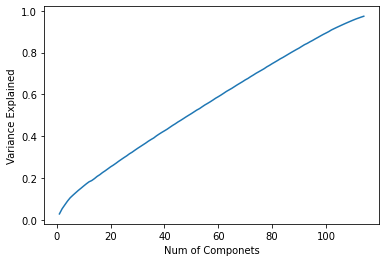

In [108]:
# view the explained variance for the different number of features
plt.plot(range(1,115), explained_variance)
plt.xlabel('Num of Componets')
plt.ylabel('Variance Explained')

In [109]:
# pick number of features to use for model based of of plot
pca_model_95 = PCA(n_components=95)

In [110]:
# create X train and test for just selected features
select_train = pca_model_95.fit_transform(X_train)
select_test = pca_model_95.transform(X_test)

In [111]:
# fit on linear regression model
lr_base.fit(select_train, y_train)

LinearRegression()

In [112]:
# view performance
performance_selection(lr_base, select_test, y_test)

Test Mean Absolute Error : 1.6
Test Mean Squared Error: 5.54
Test Root Mean Square Error :$ 2.35
Train Root Mean Square Error :$ 1.95


## 5. Results
---

### The Final Model:
The final model in this analysis is the model with the lowest RMSE which was a Random Forest model. The Random Forest Model went through hyperparameter tuning using GridsearchCV and feature selection was performed using the top 20 percent of features found by using filter method ANOVA. 

In [171]:
# recall the parameters of the best performing Random Forest model
gridsearch_rf1.best_params_

{'criterion': 'squared_error',
 'max_depth': 75,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 5}

In [173]:
# recall results of best perfoming model after tuning and feature selection

print('Final Model Metrics:')
performance_selection(precent20_rf, select_test, y_test)

# Save as image
plt.savefig("Images/model_results.png", dpi=150, bbox_inches = "tight")

Final Model Metrics:
Test Mean Absolute Error : 1.45
Test Mean Squared Error: 4.09
Test Root Mean Square Error :$ 2.02
Train Root Mean Square Error :$ 1.39


<Figure size 432x288 with 0 Axes>

Random Forest models work well here since they are more robost to outliers and have a lower rist of over fitting than some other models. However it is important to keep in mind that Random Forest models are sensitive to categorical data which this dataset does contain a good amount of. 

#### What can be learned from this analysis?

The goal of this analysis was to gain information about the New Orleans short term rental market using exploratory data analysis and a price predictive model that Ms. Alter could use as in aid while searching for an investment property.

The exploratory Data Analysis (EDA) can assist in making general assumptions about New Orleans' short term rental market, that you can use to help narrow down properties in your search. EDA showed which neighborhoods had the most airbnbs and which neighborhoods had the most expensive rentals. EDA also showed that entire properties book more and rent for more than shared properties. 

The machine learning analysis showed that there is enough good data to develop a predictive model that correctly predicts the nightly rate within $2.02. The final model had an MAE of 1.45 on the test set. The MAE is a metric that gives us the absolute difference between actual and predicted values. Having a well performing predictive model will prove helpful when comparing properties to buy and help you determine not only the price point you should expect to rent a property at but also help you decide what your purchase price for a property should be around to get the ROI that works for you. 

The final model had a RMSE of $2.02 which is the root square error of the entire model's error. The RMSE helps us understand how spread out the data is around the line of best fit by using the difference between the observed values and the predicted values. The final model went through feature selection. Feature selection can help improve a model because it can reduce overfitting and remove possible redundant features, which helps remove noise that can harm and distract the data. As well, feature selection in this analysis removed mostly categorical features but kept most of the continuous features. Having a goo

## 6. Conclusion
---

The business problem was to gain an a general understanding of New Orleans, LA short term rental market and make a predictive model for the nightly price of an Airbnb in New Orleans. This analysis was completed for Sarah Alter, a private investor, who is interested in expanding her vacation rental portfolio to New Orleans. This analysis is to be used as a guide as Alter starts her search for a new property. To help Alter reach her goal, exploratory data analysis is used to get an overview of the market. This analysis also provides a price predicting model. A predictive model would be informative when applied to current properties on the market to help Alter get a grasp on what nightly rates she can expect based on specific features of the property. 

The final model was a Random Forest model. In summary this analysis showed:
- The final model had an RMSE of $2.02 on the test set.
- The final model had a MAE of 1.45 on the test set.
- The Exploratory Data Analysis shows to be informative in getting an general understanding of the New Orleans' Short term rental market to aid Alter in her property search. Such as which neighborhoods have the highest priced airbnbs and the lowest availability. 

#### Next steps:

Adding more continuous & relevant variables. New Orleans is a large city and even within each neighborhood price data can vary. Reflecting on what makes a Short Term Rental attractive to tourists and adding those features into the model can help get even a better representation of the New Orleans market. Such features which might be interesting to add is distance to the airport and top tourist attractions. More features can be added to this model using API to source this data from places such as Google Earth. 

Take into consideration seasonality. This dataset is based around November 7, 2021. However, it is not noted whether it is the main season for New Orleans or not. Importing data from Inside Airbnb for different times of the year might show different price predictions and endup changing your expected ROI.  

Use what was gathered from EDA to further investigate specific neighborhoods. EDA showed which neighborhoods had the most Airbnbs. Researching those neighborhoods might show that they have benefits that other neighborhoods don't, such as less restrictions or qualifications placed on them by the city or county.
 